<a href="https://colab.research.google.com/github/haticeaxu/ai-models-collection/blob/main/YSA_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121, MobileNet
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import os
import random


In [ ]:
# Veri seti dizinleri
image_folder = '/content/drive/MyDrive/data'
mask_dir = os.path.join(image_folder, "with_mask")
no_mask_dir = os.path.join(image_folder, "without_mask")

In [ ]:

# Eğitim ve test setlerini oluşturma
all_images = []
labels = []

mask_images = [os.path.join(mask_dir, img) for img in os.listdir(mask_dir)]
no_mask_images = [os.path.join(no_mask_dir, img) for img in os.listdir(no_mask_dir)]


In [ ]:
# Rastgele 500 görüntü seçme
random.seed(42)  # Rastgeleliği kontrol etmek için
if len(mask_images) >= 500:
    mask_images = random.sample(mask_images, 500)
if len(no_mask_images) >= 500:
    no_mask_images = random.sample(no_mask_images, 500)

In [ ]:
# Seçilen görüntüleri listeye ekleme
all_images.extend(mask_images)
labels.extend(["mask"] * len(mask_images))

all_images.extend(no_mask_images)
labels.extend(["no_mask"] * len(no_mask_images))


In [ ]:
# Veriyi eğitim (%80) ve test (%20) olarak ayırma
train_images, test_images, train_labels, test_labels = train_test_split(
    all_images, labels, test_size=0.2, random_state=42
)


In [ ]:
# Eğitim ve validasyon setlerini ayırma (Eğitim %80, Validasyon %20)
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42
)

In [ ]:
# Görüntü işleme için ImageDataGenerator kullanımı
datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': train_images, 'class': train_labels}),
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_generator = datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': val_images, 'class': val_labels}),
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = ImageDataGenerator(rescale=1.0/255).flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': test_images, 'class': test_labels}),
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 640 validated image filenames belonging to 2 classes.
Found 160 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.


In [ ]:
# DenseNet121 Modeli oluşturma
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Modeli dondur ve bazı katmanları serbest bırak
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Modeli derleme
model.compile(
    optimizer=SGD(learning_rate=0.001, momentum=0.9),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)


In [ ]:
# Modeli eğitme
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 297s 14s/step - accuracy: 0.4987 - loss: 0.6953 - val_accuracy: 0.9500 - val_loss: 0.5146 - learning_rate: 0.0010
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 168s 9s/step - accuracy: 0.7839 - loss: 0.5220 - val_accuracy: 0.9688 - val_loss: 0.3276 - learning_rate: 0.0010
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 172s 9s/step - accuracy: 0.9200 - loss: 0.3557 - val_accuracy: 0.9875 - val_loss: 0.1769 - learning_rate: 0.0010
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 177s 9s/step - accuracy: 0.9302 - loss: 0.2273 - val_accuracy: 0.9750 - val_loss: 0.0985 - learning_rate: 0.0010
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 175s 9s/step - accuracy: 0.9689 - loss: 0.1549 - val_accuracy: 0.9875 - val_loss: 0.0665 - learning_rate: 0.0010
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 167s 8s/step - accuracy: 0.9579 - loss: 0.1217 - val_accuracy: 0.9750 - val_loss: 0.0663 - learning_rate: 0.0010
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 204s 9s/step - accuracy: 0.9614 - loss: 0.1142 - val_ac

In [ ]:
model_save_path = os.path.join(os.getcwd(), "mask_detector_model.h5")
model.save(model_save_path)
print(f"Model kaydedildi: {model_save_path}")

Model kaydedildi: /content/mask_detector_model.h5


In [ ]:
# Test verisi ile tahmin yapma
y_pred = model.predict(test_generator)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()
y_true = test_generator.classes

7/7 ━━━━━━━━━━━━━━━━━━━━ 39s 5s/step


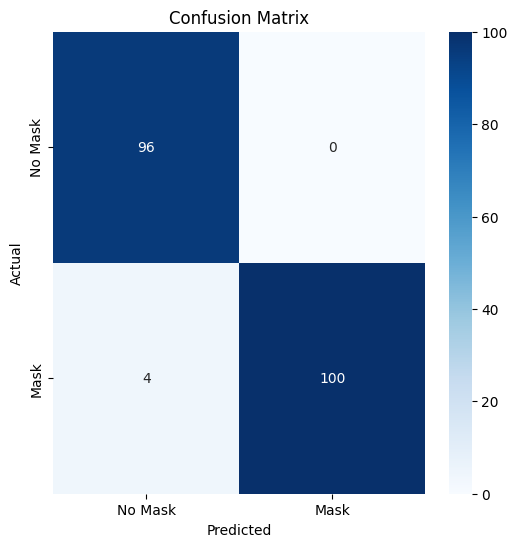

In [ ]:
# Karışıklık Matrisi
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Mask', 'Mask'], yticklabels=['No Mask', 'Mask'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Sınıflandırma raporu
print(classification_report(y_true, y_pred_classes))


              precision    recall  f1-score   support

           0       0.96      1.00      0.98        96
           1       1.00      0.96      0.98       104

    accuracy                           0.98       200
   macro avg       0.98      0.98      0.98       200
weighted avg       0.98      0.98      0.98       200



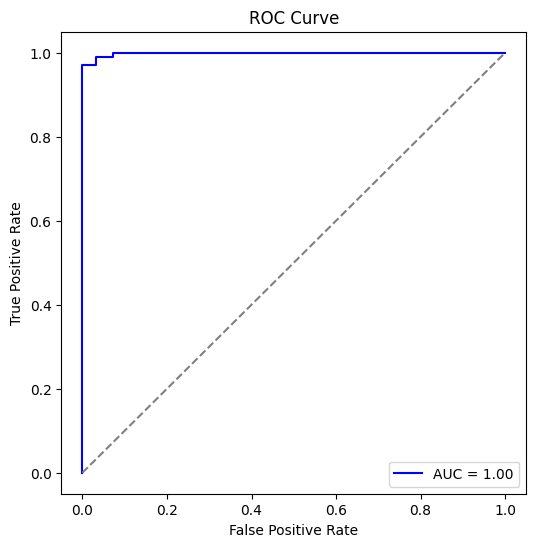

In [ ]:
# ROC Eğrisi
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()